# Predicción de precios de Bitcoin con algoritmos de aprendizaje profundo
## Elaborado por: Ronny Meza

In [1]:
#Librerias
import os
import numpy as np
import pandas as pd
import pickle
import quandl
from datetime import datetime
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
from datetime import date, timedelta
from dateutil.parser import parse
import pandas as pd

from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
from random import randint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.callbacks import EarlyStopping
from keras import initializers
from matplotlib import pyplot
from datetime import datetime
from matplotlib import pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
%matplotlib inline
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

#Recuperacion de los precios del Bitcoin utilizando el Api Quandl, para adquirir los datos se requiere de una clave
quandl.ApiConfig.api_key = '9xDDcwCoVbqfi1LxtrHv'


Using TensorFlow backend.


In [2]:
#Función para la recuperación de los datos mediante la herramienta Bitcoin Data
def get_quandl_data(quandl_id):
    '''Descarga de la serie de datos Quandl'''
    cache_path = '{}.pkl'.format(quandl_id).replace('/','-')
    try:
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(quandl_id))
    except (OSError, IOError) as e:
        print('Downloading {} from Quandl'.format(quandl_id))
        df = quandl.get(quandl_id, returns="pandas")
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(quandl_id, cache_path))
    return df

In [3]:
# Extracción de los precios de intercambio del kraken directamente en euros
btc_eur_price_kraken = quandl.get('BCHARTS/KRAKENEUR',start_date="2014-01-01", end_date=date.today())

In [4]:
#Inspeccion de los datos
btc_eur_price_kraken.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-01-08,624.01000,640.00000,600.00000,613.47231,331.481650,204958.394492,618.309926
2014-01-09,613.47231,626.99990,590.00000,614.22456,583.334331,355744.845866,609.847265
2014-01-10,615.00000,630.00000,605.00000,625.73866,323.047379,199327.057887,617.021127
2014-01-11,626.17401,658.99999,623.30000,653.89888,561.256792,361578.576476,644.230202
2014-01-12,653.89888,659.98000,613.00555,625.26660,477.757931,302729.099050,633.645366


In [5]:
# Generacion de un grafico simple para evaluar la fluctuacion
btc_trace = go.Scatter(x=btc_eur_price_kraken.index, y=btc_eur_price_kraken['Weighted Price'])
py.iplot([btc_trace])

In [6]:
#Debido a las bajadas abrutas se procede a descargar los datos de otras paginas
# Pull pricing data for 3 more BTC exchanges
exchanges = ['COINBASE','BITSTAMP','ITBIT']

exchange_data = {}

exchange_data['KRAKEN'] = btc_eur_price_kraken

for exchange in exchanges:
    exchange_code = 'BCHARTS/{}EUR'.format(exchange)
    btc_exchange_df = quandl.get(exchange_code,start_date="2014-01-01", end_date=date.today())
    exchange_data[exchange] = btc_exchange_df

In [7]:
#Creación de una funcion para fusionar base de datos
def merge_dfs_on_column(dataframes, labels, col):
    '''Merge a single column of each dataframe into a new combined dataframe'''
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][col]
        
    return pd.DataFrame(series_dict)

In [8]:
# Fusión de las base de datos
btc_eur_datasets = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Weighted Price')

In [9]:
# Previsualizacion de los resultados
btc_eur_datasets.tail()

,KRAKEN,COINBASE,BITSTAMP,ITBIT
Date,,,,
2018-09-15,5610.906582,5623.260200,5613.322034,5608.267239
2018-09-16,5563.882659,5582.082281,5569.103945,5540.571591
2018-09-17,5434.386679,5444.369812,5436.330109,5406.054764
2018-09-18,5400.358731,5406.612313,5401.802059,5418.100711
2018-09-19,5419.520029,5428.165066,5412.861561,5441.571620


In [10]:
#Función para comparar los precios de las diferentes bases de datos
def df_scatter(df, title, seperate_y_axis=False, y_axis_label='', scale='linear', initial_hide=False):
    '''Generate a scatter plot of the entire dataframe'''
    label_arr = list(df)
    series_arr = list(map(lambda col: df[col], label_arr))
    
    layout = go.Layout(
        title=title,
        legend=dict(orientation="h"),
        xaxis=dict(type='date'),
        yaxis=dict(
            title=y_axis_label,
            showticklabels= not seperate_y_axis,
            type=scale
        )
    )
    
    y_axis_config = dict(
        overlaying='y',
        showticklabels=False,
        type=scale )
    
    visibility = 'visible'
    if initial_hide:
        visibility = 'legendonly'
        
    # Form Trace For Each Series
    trace_arr = []
    for index, series in enumerate(series_arr):
        trace = go.Scatter(
            x=series.index, 
            y=series, 
            name=label_arr[index],
           
        )
        
        # Add seperate axis for the series
        if seperate_y_axis:
            trace['yaxis'] = 'y{}'.format(index + 1)
            layout['yaxis{}'.format(index + 1)] = y_axis_config    
        trace_arr.append(trace)

    fig = go.Figure(data=trace_arr, layout=layout)
    py.iplot(fig)

In [11]:
# Grafico de todos los precios del Bitc
df_scatter(btc_eur_datasets, 'Precios del Bitcoin al cambio (EUR)')

In [12]:
#Remocion de valores nulos
btc_eur_datasets.replace(0, np.nan, inplace=True)

In [13]:
# Grafico de los datos limpios
df_scatter(btc_eur_datasets, 'Precios del Bitcoin al cambio (EUR)')

In [14]:
# Cálculo del valor promedio del precio de venta 
btc_eur_datasets['avg_btc_price_eur'] = btc_eur_datasets.mean(axis=1)

In [15]:
# Gráobtener predicciones y luego hacer algunas transformaciones para poder calcular RMSE correctamente en USDfico del valor promedio del precio de venta
btc_trace = go.Scatter(x=btc_eur_datasets.index, y=btc_eur_datasets['avg_btc_price_eur'])
py.iplot([btc_trace])

In [16]:
# Previsualizacion de los resultados, la ultima columna son los datos depurados
btc_eur_datasets.tail()

,KRAKEN,COINBASE,BITSTAMP,ITBIT,avg_btc_price_eur
Date,,,,,
2018-09-15,5610.906582,5623.260200,5613.322034,5608.267239,5613.939014
2018-09-16,5563.882659,5582.082281,5569.103945,5540.571591,5563.910119
2018-09-17,5434.386679,5444.369812,5436.330109,5406.054764,5430.285341
2018-09-18,5400.358731,5406.612313,5401.802059,5418.100711,5406.718453
2018-09-19,5419.520029,5428.165066,5412.861561,5441.571620,5425.529569


In [17]:
#Creacion de los datos de entrenamiento y prueba
d0 = date(2014, 1, 1)
d1 = date(2017, 12, 17)
delta = d1 - d0
days_look = delta.days + 1
print(days_look)

#Se toma la ventana de analisis hasta el dia de ayer
d0 = date(2017, 12, 18)
#d1 = date(2018,7, 31)
d1 = date.today()
delta = d1 - d0
days_from_train = delta.days +1
print(days_from_train)

#d0 = date(2018,7, 31) + timedelta(1)
#d1 = date(2018,7, 31) + timedelta(7)
d0 = date.today() + timedelta(1)
d1 = date.today() + timedelta(7)
delta = d1 - d0
days_from_end = delta.days +1
print(days_from_end)

1447
277
7


In [18]:
#Creación de un dataframe con los datos de interes
data_end=(days_look+days_from_train)
mean_price =  btc_eur_datasets[['avg_btc_price_eur']][0:data_end]
mean_price.tail()

,avg_btc_price_eur
Date,
2018-09-15,5613.939014
2018-09-16,5563.910119
2018-09-17,5430.285341
2018-09-18,5406.718453
2018-09-19,5425.529569


In [19]:
#Imputacion de datos perdidos (Utilizar para los datos del grafico de velas)
from sklearn.preprocessing import Imputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

mean_price = btc_eur_datasets[['avg_btc_price_eur']]

imp=Imputer(missing_values="NaN", strategy="median" )
imp.fit(mean_price)
mean_price["avg_btc_price_eur"]=imp.transform(mean_price[["avg_btc_price_eur"]]).ravel()

df_scatter(mean_price, 'Imputacion de datos Perdidos para los Precios del Bitcoin al cambio (EUR)')
#respaldo de la erie completa
real_data = mean_price

In [20]:
#Revision de valores nulos en los datos
None in mean_price

False

In [21]:
#División de los datos en el conjunto de entrenamiento y pruebas
df_train= mean_price[0:days_look]
x_train = mean_price.index[0:days_look]
data_end=(days_look+days_from_train)
print(data_end)

df_test= mean_price[len(df_train):data_end]
x_test = mean_price.index[len(df_train):data_end]

#Número de datos de entrenamiento y prueba respectivamente
print(len(df_train), len(df_test)) 

#Último día de la serie
print(x_test[-1]) #En ocasiones el modulo de descarga de datos falla y no los descarga completos
print(len(x_test))

1724
1447 276
2018-09-19 00:00:00
276


In [22]:
#Construcción de los datos de entrenamiento y prueba
working_data = [df_train, df_test]
working_data = pd.concat(working_data)

working_data = working_data.reset_index()
working_data['Date'] = pd.to_datetime(working_data['Date'])
working_data = working_data.set_index('Date')


In [23]:
#Estructuración de los datos de entrenamiento y prueba
df_train = working_data [0:days_look]
df_test = working_data [len(df_train):data_end]
print(len(df_train), len(df_test))

1447 276


In [24]:
#Preparación de los datos para validacion cruzada
def create_lookback(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [25]:
#Función para prepación y reajuste de los datos
from sklearn.preprocessing import MinMaxScaler

training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
test_set = df_test.values
test_set = np.reshape(test_set, (len(test_set), 1))

#Escalamiento de los datos
scaler = MinMaxScaler()
training_set = scaler.fit_transform(training_set)
test_set = scaler.transform(test_set)

# Creación del conjunto de datos con el cual se realizara la predicción 
look_back = 1
X_train, Y_train = create_lookback(training_set, look_back)
X_test, Y_test = create_lookback(test_set, look_back)

# Reajuste de los datos de acuerdo a los requerimientos del motor LSTM de Keras
X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

In [26]:
#Entrenando la red neuronal de 2 capas LSTM
#Inicialización secuencial del modelo, con 2 capas y densamente conectado con la neurona de salida
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(256))
model.add(Dense(1))

# Compilación y ajuste del modelo
#Por defecto, las muestras dentro de una época se barajan antes de ser expuestas a la red, esto no es deseable para LSTM, 
#por lo cual se deshabilita la mezcla de muestras ajustando " shuffle " igual a " False ".
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, Y_train, epochs=150, batch_size=16, shuffle=False,
                    validation_data=(X_test, Y_test),
                    callbacks = [EarlyStopping(monitor='val_loss', min_delta=2e-5, patience=20, verbose=1)])


Train on 1446 samples, validate on 275 samples
Epoch 1/150
1446/1446 [==============================] - 4s 2ms/step - loss: 0.0014 - val_loss: 0.0097
Epoch 2/150
1446/1446 [==============================] - 2s 1ms/step - loss: 0.0162 - val_loss: 0.0435
Epoch 3/150
1446/1446 [==============================] - 2s 1ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 4/150
1446/1446 [==============================] - 2s 1ms/step - loss: 0.0020 - val_loss: 9.8195e-04
Epoch 5/150
1446/1446 [==============================] - 2s 1ms/step - loss: 5.9214e-05 - val_loss: 7.3762e-04
Epoch 6/150
1446/1446 [==============================] - 2s 1ms/step - loss: 1.3270e-04 - val_loss: 9.4914e-04
Epoch 7/150
1446/1446 [==============================] - 2s 1ms/step - loss: 7.2182e-05 - val_loss: 7.9765e-04
Epoch 8/150
1446/1446 [==============================] - 2s 1ms/step - loss: 2.1318e-04 - val_loss: 9.7108e-04
Epoch 9/150
1446/1446 [==============================] - 2s 1ms/step - loss: 1.7140e-04 - val

In [27]:
trace1 = go.Scatter(
    x = np.arange(0, len(history.history['loss']), 1),
    y = history.history['loss'],
    mode = 'lines',
    name = 'Perdidas durante el entrenamiento',
    line = dict(color=('rgb(66, 244, 155)'), width=2, dash='dash')
)
trace2 = go.Scatter(
    x = np.arange(0, len(history.history['val_loss']), 1),
    y = history.history['val_loss'],
    mode = 'lines',
    name = 'Perdidas durante la validación',
    line = dict(color=('rgb(244, 146, 65)'), width=2)
)

data = [trace1, trace2]
layout = dict(title = 'Perdidas durante la etapa de entrenamiento y validación',
              xaxis = dict(title = 'Número de Epocas'), yaxis = dict(title = 'Perdidas'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='Proceso de Entrenamiento')

In [28]:
# Código para alinear las fases de las predicciones y las etiquetas
X_test = np.append(X_test, scaler.transform(working_data.iloc[-1][0]))
X_test = np.reshape(X_test, (len(X_test), 1, 1))

# Se obtienen las predicciones y se devuelven las transformaciones para poder calcular RMSE correctamente
prediction = model.predict(X_test)
prediction_inverse = scaler.inverse_transform(prediction.reshape(-1, 1))
Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))
prediction2_inverse = np.array(prediction_inverse[:,0][1:])
Y_test2_inverse = np.array(Y_test_inverse[:,0])

In [29]:
#Predicción n días hacia adelante
n = 7
long = len(X_test)
w1 = long - n

data_1 = X_test[w1:(w1+n)]
data_2 = np.concatenate((X_test, data_1))

# obtener las predicciones y se devuelven las transformaciones para poder calcular RMSE correctamente
prediction_7d = model.predict(data_2)
prediction_inverse_7d = scaler.inverse_transform(prediction_7d.reshape(-1, 1))
prediction2_7d_inverse = np.array(prediction_inverse_7d[:,0][1:])

prediction_7db = prediction2_7d_inverse[w1:(w1+n)] 

print(prediction_7db)

[5334.281  5380.8555 5342.483  5240.1504 5222.1274 5236.513  5329.642 ]


In [30]:
#Creacion de la ventana temporal de predicción para 7 días
import matplotlib.dates as mdates
import datetime
last_day = df_test.index[-1]+timedelta(1)
print(last_day )
time_start = last_day
time_end = time_start + timedelta(7)
date_list = [time_start + timedelta(days=x) for x in range(0, 7)]
num_date = mdates.date2num(date_list)
print(date_list)

2018-09-20 00:00:00
[Timestamp('2018-09-20 00:00:00'), Timestamp('2018-09-21 00:00:00'), Timestamp('2018-09-22 00:00:00'), Timestamp('2018-09-23 00:00:00'), Timestamp('2018-09-24 00:00:00'), Timestamp('2018-09-25 00:00:00'), Timestamp('2018-09-26 00:00:00')]


In [31]:
#Creacion de la ventana temporal de predicción para n días

import matplotlib.dates as mdates
import datetime
last_day = df_test.index[-1]+timedelta(1)
print(last_day )
time_start = last_day
time_end = time_start + timedelta(n)
date_list = [time_start + timedelta(days=x) for x in range(0, n)]
num_date = mdates.date2num(date_list)
print(date_list)

2018-09-20 00:00:00
[Timestamp('2018-09-20 00:00:00'), Timestamp('2018-09-21 00:00:00'), Timestamp('2018-09-22 00:00:00'), Timestamp('2018-09-23 00:00:00'), Timestamp('2018-09-24 00:00:00'), Timestamp('2018-09-25 00:00:00'), Timestamp('2018-09-26 00:00:00')]


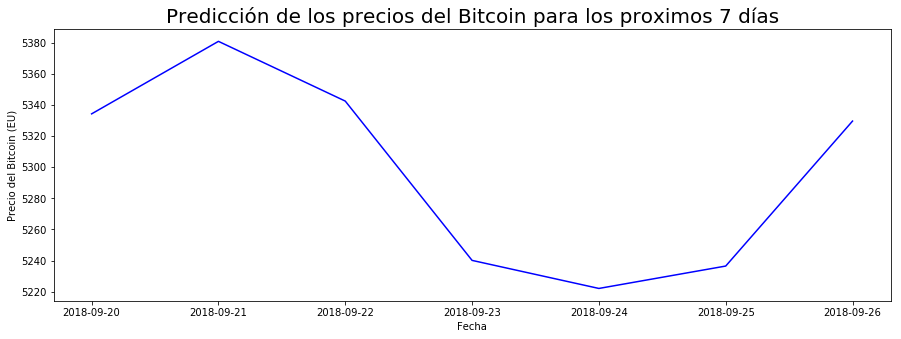

In [32]:
plt.figure(1, figsize=(15,5))
pyplot.plot(date_list, prediction_7db, '-', color = 'blue')
plt.title('Predicción de los precios del Bitcoin para los proximos 7 días', fontsize=20)
plt.xlabel('Fecha')
plt.ylabel('Precio del Bitcoin (EU)')
plt.savefig('71b_Predic_LSTM_7_dias_EU.png')
#plt.savefig('71_30d_Predic_LSTM_30_dias_EU.png')
pyplot.show() 

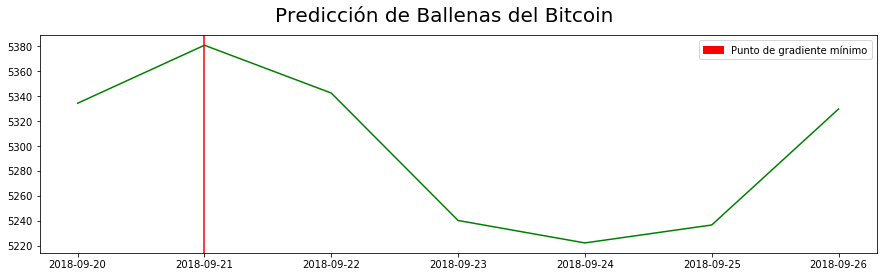

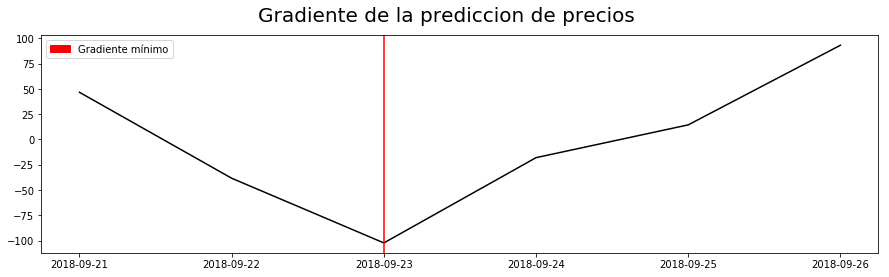

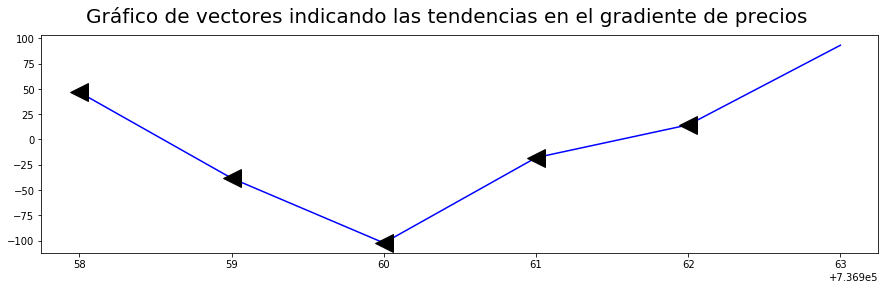

In [33]:
import matplotlib.patches as mpatches
y = np.diff(prediction_7db)
y =list(y)
minpos = y.index(np.min(y))
maxpos = y.index(np.max(y))

minimo = y[minpos]
maximo = y[maxpos]
x_min = date_list[minpos]
x_max= date_list[maxpos]

plt.figure(figsize=(15,4))
pyplot.plot(date_list, prediction_7db, color='green')

plt.axvline(x=x_min-timedelta(1), color = 'red')
red_patch = mpatches.Patch(color='red', label='Punto de gradiente mínimo')
plt.legend(handles=[red_patch])
plt.suptitle('Predicción de Ballenas del Bitcoin', fontsize=20)
plt.savefig('72a_whale_prediction.png')

plt.show()
plt.figure(figsize=(15,4))
pyplot.plot(date_list[1:len(date_list)], y, color='k')
plt.axvline(x=x_min+timedelta(1), color = 'red')
red_patch = mpatches.Patch(color='red', label='Gradiente mínimo')
plt.legend(handles=[red_patch])
plt.suptitle('Gradiente de la prediccion de precios', fontsize=20)
plt.savefig('72b_whale_prediction.png')
plt.show()

import numpy as np
import matplotlib.pyplot as plt; plt.ion()
from matplotlib.patches import FancyArrowPatch

eje_x = mdates.date2num(date_list)
x = eje_x[1:30]


# use masked arrays
x1 = np.ma.masked_array(x[:-1], np.diff(x)>=0)
x2 = np.ma.masked_array(x[:-1], np.diff(x)<=0)

# print the line and the markers in seperate steps
plt.figure(figsize=(15,4))
plt.plot(x, y, '-', color ='blue')


plt.plot(x1, y[:-1], 'k>', markersize = 18)
plt.plot(x2, y[:-1], 'k<', markersize = 18)
plt.suptitle('Gráfico de vectores indicando las tendencias en el gradiente de precios', fontsize=20)
plt.savefig('72c_whale_prediction.png')
plt.show()

In [35]:
print(prediction_7db)

[5334.281  5380.8555 5342.483  5240.1504 5222.1274 5236.513  5329.642 ]


In [36]:
trace1 = go.Scatter(
    x = np.arange(0, len(prediction2_inverse), 1),
    y = prediction2_inverse,
    mode = 'lines',
    name = 'Predicción de precios',
    line = dict(color=('rgb(244, 146, 65)'), width=2)
)
trace2 = go.Scatter(
    x = np.arange(0, len(Y_test2_inverse), 1),
    y = Y_test2_inverse,
    mode = 'lines',
    name = 'Precios reales',
    line = dict(color=('rgb(66, 244, 155)'), width=2)
)

data = [trace1, trace2]
layout = dict(title = 'Precios reales versus la predicción del modelo',
             xaxis = dict(title = 'Número de Días'), yaxis = dict(title = 'Precio (EUR)'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating0')

In [37]:
#Calculo del error RMS
RMSE  = sqrt (mean_squared_error (Y_test2_inverse, prediction2_inverse))
print ( ' Error RMSE: % .3f '  %  RMSE )
Test_Dates = mean_price[len(mean_price)-days_from_train:].index

MAE_error = mean_absolute_error(Y_test2_inverse, prediction2_inverse)

print('Error MAE del Modelo: %.3f' % MAE_error)

 Error RMSE:  702.021 
Error MAE del Modelo: 575.625


In [38]:
#Extraccion de grafico en la ventana deseada
#Creacion de los datos 

#Se toma la ventana de analisis hasta el dia de ayer
d0a = date(2018, 7, 31)
d1a = date.today()
delta1 = d1a - d0a
days_from_train_7 = delta1.days -1
print(days_from_train_7)
d2 = date(2018, 8, 7)
delta2 = d1a - d2
days_actual = delta2.days -1
print(days_actual)

50
43


In [39]:
#Y_test2_inverse
X_date= Test_Dates[-days_from_train_7:-days_actual]
Y_data =  prediction2_inverse[-days_from_train_7:-days_actual]
Y_real = mean_price.values[-days_from_train_7:-days_actual]

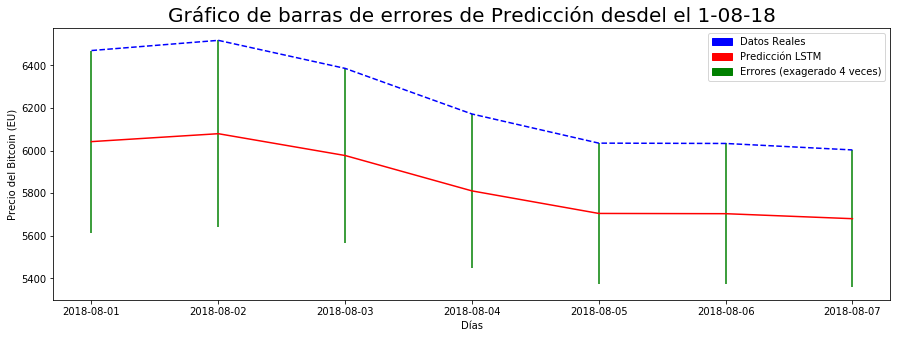

In [43]:
error_diario = (Y_real.T - Y_data)
x = [1,2,3,4,5,6,7]
plt.figure(1, figsize=(15,5))
error_diario = error_diario.T
error_diario = error_diario.reshape((error_diario.shape[0],))

plt.errorbar(X_date, Y_data, yerr=error_diario, color='red', fmt='-', ecolor='g')
pyplot.plot(X_date, Y_real, '--', color = 'blue')

plt.title('Gráfico de barras de errores de Predicción desdel el 1-08-18', fontsize=20)
plt.xlabel('Días')
plt.ylabel('Precio del Bitcoin (EU)')
red_patch = mpatches.Patch(color='red', label='Predicción LSTM')
green_patch = mpatches.Patch(color='green', label= 'Errores (exagerado 4 veces)')
blue_patch = mpatches.Patch(color='blue', label='Datos Reales')

plt.legend(handles=[blue_patch, red_patch, green_patch])
plt.savefig('71_Error_Predic_LSTM_7_dias_EU.png')
plt.show()


In [44]:
#Cálculo del error RMS

Y_real = Y_real.reshape((Y_real.shape[0],))

RMSE_new = sqrt(mean_squared_error(Y_real.T, Y_data))

print('Error RMSE promedio del Modelo GRU: %.3f' % RMSE_new)

MAE_error = mean_absolute_error(Y_real.T, Y_data)
print('Error MAE del Modelo GRU: %.3f' % MAE_error)

Error RMSE promedio del Modelo GRU: 376.777
Error MAE del Modelo GRU: 373.941


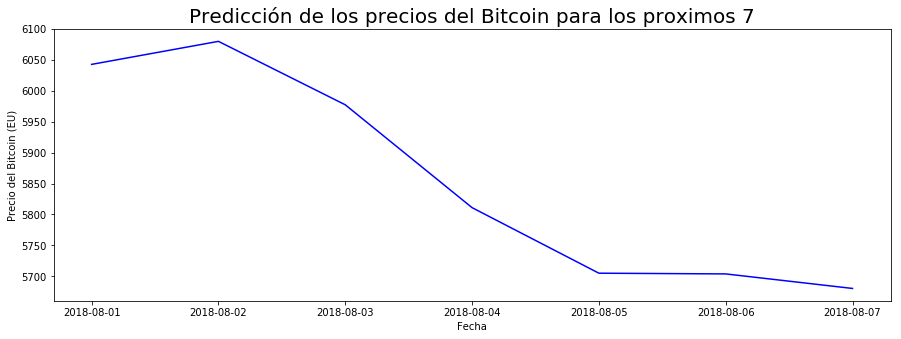

In [45]:
plt.figure(1, figsize=(15,5))
pyplot.plot(X_date, Y_data, '-', color = 'blue')
plt.title('Predicción de los precios del Bitcoin para los proximos 7', fontsize=20)
plt.xlabel('Fecha')
plt.ylabel('Precio del Bitcoin (EU)')
plt.savefig('71b_Predic_LSTM_7_dias_EU.png')
#plt.savefig('71_30d_Predic_LSTM_30_dias_EU.png')
pyplot.show() 

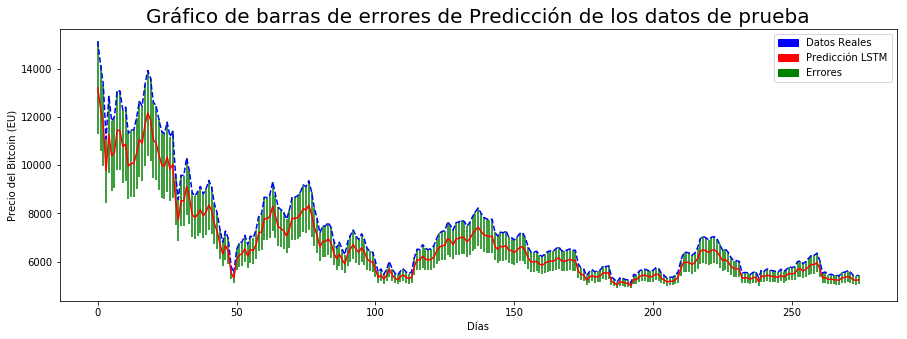

In [48]:
import matplotlib.patches as mpatches
error_diario = (Y_test2_inverse - prediction2_inverse)

x = np.arange(0, len(prediction2_inverse), 1)
#Gráfico de errores
plt.figure(1, figsize=(15,5))
plt.errorbar(x, prediction2_inverse, yerr=error_diario, color='red', fmt='-', ecolor='g')
pyplot.plot(x, Y_test2_inverse, '--', color = 'blue')
plt.title('Gráfico de barras de errores de Predicción de los datos de prueba', fontsize=20)
plt.xlabel('Días')
plt.ylabel('Precio del Bitcoin (EU)')
red_patch = mpatches.Patch(color='red', label='Predicción LSTM')
green_patch = mpatches.Patch(color='green', label= 'Errores')
blue_patch = mpatches.Patch(color='blue', label='Datos Reales')

plt.legend(handles=[blue_patch, red_patch, green_patch])
plt.savefig('63b_Errores_Predicion_LSTM_Test_EUR.png')
plt.show()

In [47]:
#Gráfico de comparación
Test_Dates = mean_price[len(mean_price)-days_from_train:].index

trace1 = go.Scatter(x=Test_Dates, y=Y_test2_inverse, name= 'Precios reales',
                   line = dict(color = ('rgb(66, 244, 155)'),width = 2))
trace2 = go.Scatter(x=Test_Dates, y=prediction2_inverse, name= 'Predicción de precios',
                   line = dict(color = ('rgb(244, 146, 65)'),width = 2))
data = [trace1, trace2]
layout = dict(title = 'Precios reales versus predicción del modelo',
             xaxis = dict(title = 'Fecha (meses)'), yaxis = dict(title = 'Precio (EUR)'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating1')

In [49]:
# Modelo GRU
# Esta función prepara una división aleatoria de datos de entrenamiento y prueba
# Escalamiento de los datos con la función MinMaxScaler y creación de etiquetas de series de tiempo (Y)

def get_split(working_data, n_train, n_test, look_back = 1):
    # Se obtiene un punto desde el cual se construye el conjunto de datos de entrenamiento y los datos de prueba
    start_point = randint(0, (len(working_data)-n_test-n_train))
    df_train = working_data[start_point:start_point+n_train]
    df_test = working_data[start_point+n_train:start_point+n_train+n_test]

    training_set = df_train.values
    training_set = np.reshape(training_set, (len(training_set), 1))
    test_set = df_test.values
    test_set = np.reshape(test_set, (len(test_set), 1))

    # Escalamiento de los datos
    scaler_cv = MinMaxScaler()
    training_set = scaler_cv.fit_transform(training_set)
    test_set = scaler_cv.transform(test_set)

    # creación de un conjuntos de datos que luego son ajustados para la predicción de las series de tiempo
    X_train, Y_train = create_lookback(training_set, look_back)
    X_test, Y_test = create_lookback(test_set, look_back)

    # Reajustar los datos para que se ajusten a los requerimientos de Keras
    X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

    return X_train, Y_train, X_test, Y_test, scaler_cv, start_point

# Esta función toma los datos de la funcion previa como entrada y entrena un modelo
def train_model(X_train, Y_train, X_test, Y_test):
    # se inicializa el modelo secuencial, se agrega la capa LSTM bidireccional y la neurona de salida densamente conectada
    model = Sequential()
    model.add(GRU(256, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))

    # Compila y ajusta el modelo
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs = 100, batch_size = 16, shuffle = False,
                    validation_data=(X_test, Y_test), verbose=0,
                    callbacks = [EarlyStopping(monitor='val_loss',min_delta=5e-5,patience=20,verbose=0)])
    return model

# Esta función toma el modelo entrenado, y evalua los datos de prueba para cálcular el error RMSE
def get_rmse(model, X_test, Y_test, scaler, start_point, working_data, n_train):
    
    # Se agrega un punto de datos adicional para alinear las formas de las predicciones y las etiquetas verdaderas
    X_test = np.append(X_test, scaler.transform(working_data.iloc[start_point+n_train+len(X_test)][0]))
    X_test = np.reshape(X_test, (len(X_test), 1, 1))

    # Se toman las predicciones y se devuelven los cambios para poder calcular el error RMSE
    prediction = model.predict(X_test)
    prediction_inverse = scaler.inverse_transform(prediction.reshape(-1, 1))
    Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))
    prediction2_inverse = np.array(prediction_inverse[:,0][1:])
    Y_test2_inverse = np.array(Y_test_inverse[:,0])

    #Cálculo del RMSE
    RMSE = sqrt(mean_squared_error(Y_test2_inverse, prediction2_inverse))
    return RMSE, prediction2_inverse

In [50]:
def workflow(working_data, get_split, train_model, get_rmse,n_train = 250,n_test = 50,look_back = 1):
    X_train, Y_train, X_test, Y_test, scaler, start_point = get_split(working_data, n_train, n_test)
    model = train_model(X_train, Y_train, X_test, Y_test)
    RMSE, predictions = get_rmse(model, X_test, Y_test, scaler, start_point, working_data, n_train)
    return RMSE, predictions

In [51]:
n_train = len(df_train)
n_test = len(df_test)
RMSE, predictions = workflow(working_data, get_split, train_model, get_rmse, n_train, n_test)
print('Error RMSE del modelo GRU: %.3f' % RMSE)

Error RMSE del modelo GRU: 177.190


In [52]:
# Esta función repite el flujo de trabajo 10 veces y calcula el error promedio RMSE
def cross_validate(working_data,get_split,train_model,get_rmse,workflow,n_train = 250,n_test = 50,look_back = 1):
    rmse_list = []
    for i in range(10):
        print('Iteration:', i+1)
        RMSE, _ = workflow(working_data, get_split, train_model, get_rmse, n_train, n_test, look_back)
        rmse_list.append(RMSE)
        print('Test RMSE: %.3f' % RMSE)
    mean_rmse = np.mean(rmse_list)
    return mean_rmse, rmse_list

In [53]:
#Función de validacion cruzada del RMSE
mean_rmse, rmse_list = cross_validate(working_data, get_split, train_model, get_rmse, workflow)
print('Average RMSE: ', mean_rmse)
print('RMSE list:', rmse_list)

Iteration: 1
Test RMSE: 2.720
Iteration: 2
Test RMSE: 38.255
Iteration: 3
Test RMSE: 3.440
Iteration: 4
Test RMSE: 22.856
Iteration: 5
Test RMSE: 16.124
Iteration: 6
Test RMSE: 0.968
Iteration: 7
Test RMSE: 0.300
Iteration: 8
Test RMSE: 39.022
Iteration: 9
Test RMSE: 2.485
Iteration: 10
Test RMSE: 1.323
Average RMSE:  12.749328238650573
RMSE list: [2.7196934225314267, 38.25526143582716, 3.4401894861340243, 22.85575375089763, 16.12420713688236, 0.9680759554478302, 0.2999823945659246, 39.022036875014315, 2.485453960277584, 1.3226279689274802]


In [54]:
#Cálculo del error RMS
predictions_new = predictions - mean_rmse
RMSE_new = sqrt(mean_squared_error(Y_test2_inverse, predictions_new))

print('Error RMSE promedio del Modelo GRU: %.3f' % RMSE_new)

MAE_error = mean_absolute_error(Y_test2_inverse, predictions_new)
print('Error MAE del Modelo GRU: %.3f' % MAE_error)

Error RMSE promedio del Modelo GRU: 166.342
Error MAE del Modelo GRU: 139.783


In [55]:
trace1 = go.Scatter(x=Test_Dates, y=Y_test2_inverse, name= 'Precios reales',
                   line = dict(color = ('rgb(66, 244, 155)'),width = 2))
trace2 = go.Scatter(x=Test_Dates, y=predictions_new, name= 'Predicción de precios',
                   line = dict(color = ('rgb(244, 146, 65)'),width = 2))
data = [trace1, trace2]
layout = dict(title = 'Precios reales versus predicción del modelo Kfold-CV',
             xaxis = dict(title = 'Fecha (meses)'), yaxis = dict(title = 'Precio (EUR)'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating2')

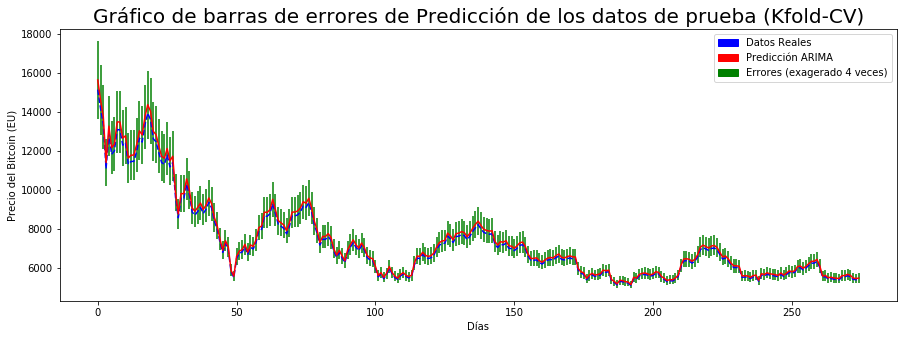

In [56]:
error_diario = (Y_test2_inverse - predictions_new)*4

x = np.arange(0, len(predictions_new), 1)
#Gráfico de errores
plt.figure(1, figsize=(15,5))
plt.errorbar(x, predictions_new, yerr=error_diario, color='red', fmt='-', ecolor='g')
pyplot.plot(x, Y_test2_inverse, '--', color = 'blue')
plt.title('Gráfico de barras de errores de Predicción de los datos de prueba (Kfold-CV)', fontsize=20)
plt.xlabel('Días')
plt.ylabel('Precio del Bitcoin (EU)')
red_patch = mpatches.Patch(color='red', label='Predicción ARIMA')
green_patch = mpatches.Patch(color='green', label= 'Errores (exagerado 4 veces)')
blue_patch = mpatches.Patch(color='blue', label='Datos Reales')

plt.legend(handles=[blue_patch, red_patch, green_patch])
plt.savefig('63c_Errores_Predicion_LSTM_Kfold_CV.png')
plt.show()

In [57]:
#Error de porcentaje absoluto medio simétrico ( SMAPE )
def symmetric_mean_absolute_percentage_error(y_true, y_pred, epsilon = 1e-8):
    return np.mean(np.abs(y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred))/2 + epsilon)) * 100

SMAPE = symmetric_mean_absolute_percentage_error(Y_test2_inverse, predictions_new)

print('SMAPE (porcentual): %.3f' % SMAPE)

SMAPE (porcentual): 1.754


In [58]:
#Extraccion de grafico en la ventana deseada
#Creacion de los datos 

#Se toma la ventana de analisis hasta el dia de ayer
d0a = date(2018, 7, 31)
d1a = date.today()
delta1 = d1a - d0a
days_from_train_7 = delta1.days -1
print(days_from_train_7)
d2 = date(2018, 8, 7)
delta2 = d1a - d2
days_actual = delta2.days -1
print(days_actual)

50
43


In [59]:
#Y_test2_inverse
X_date= Test_Dates[-days_from_train_7:-days_actual]
Y_data = predictions_new[-days_from_train_7:-days_actual]
Y_real = mean_price.values[-days_from_train_7:-days_actual]

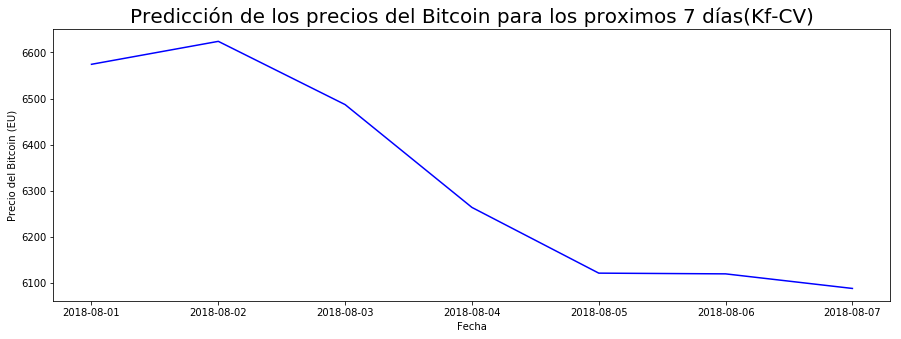

In [60]:
plt.figure(1, figsize=(15,5))
pyplot.plot(X_date, Y_data, '-', color = 'blue')
plt.title('Predicción de los precios del Bitcoin para los proximos 7 días(Kf-CV)', fontsize=20)
plt.xlabel('Fecha')
plt.ylabel('Precio del Bitcoin (EU)')
plt.savefig('77b_Predic_LSTM_7_dias_kfcv.png')
#plt.savefig('71_30d_Predic_LSTM_30_dias_EU.png')
pyplot.show() 

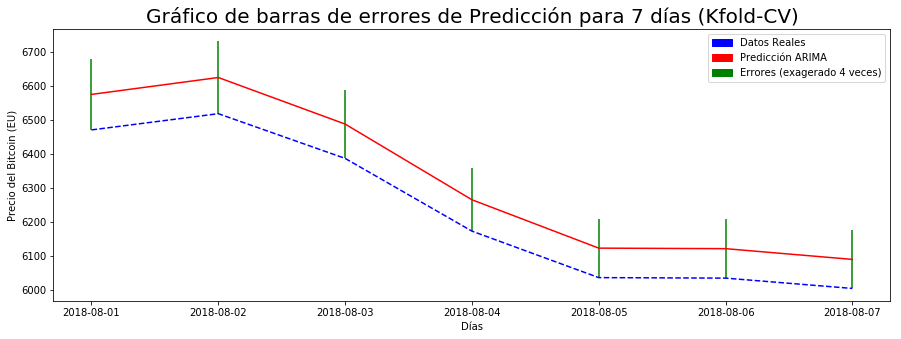

In [61]:
error_diario = (Y_real.T - Y_data)
x = [1,2,3,4,5,6,7]
plt.figure(1, figsize=(15,5))
error_diario = error_diario.T
error_diario = error_diario.reshape((error_diario.shape[0],))

plt.errorbar(X_date, Y_data, yerr=error_diario, color='red', fmt='-', ecolor='g')
pyplot.plot(X_date, Y_real, '--', color = 'blue')

plt.title('Gráfico de barras de errores de Predicción para 7 días (Kfold-CV)', fontsize=20)
plt.xlabel('Días')
plt.ylabel('Precio del Bitcoin (EU)')
red_patch = mpatches.Patch(color='red', label='Predicción ARIMA')
green_patch = mpatches.Patch(color='green', label= 'Errores (exagerado 4 veces)')
blue_patch = mpatches.Patch(color='blue', label='Datos Reales')

plt.legend(handles=[blue_patch, red_patch, green_patch])
plt.savefig('77_Errores_Predicion_LSTM_Kfold_CV_7d.png')
plt.show()


In [62]:
#Cálculo del error RMS

Y_real = Y_real.reshape((Y_real.shape[0],))

RMSE_new = sqrt(mean_squared_error(Y_real.T, Y_data))

print('Error RMSE promedio del Modelo GRU: %.3f' % RMSE_new)

MAE_error = mean_absolute_error(Y_real.T, Y_data)
print('Error MAE del Modelo GRU: %.3f' % MAE_error)

Error RMSE promedio del Modelo GRU: 95.102
Error MAE del Modelo GRU: 94.733


In [63]:
#Funcion para calcular el angulo de fase

def phase(z): 
    return np.angle(z, deg=True)

In [64]:
print((Test_Dates))

DatetimeIndex(['2017-12-17', '2017-12-18', '2017-12-19', '2017-12-20',
               '2017-12-21', '2017-12-22', '2017-12-23', '2017-12-24',
               '2017-12-25', '2017-12-26',
               ...
               '2018-09-10', '2018-09-11', '2018-09-12', '2018-09-13',
               '2018-09-14', '2018-09-15', '2018-09-16', '2018-09-17',
               '2018-09-18', '2018-09-19'],
              dtype='datetime64[ns]', name='Date', length=277, freq='D')


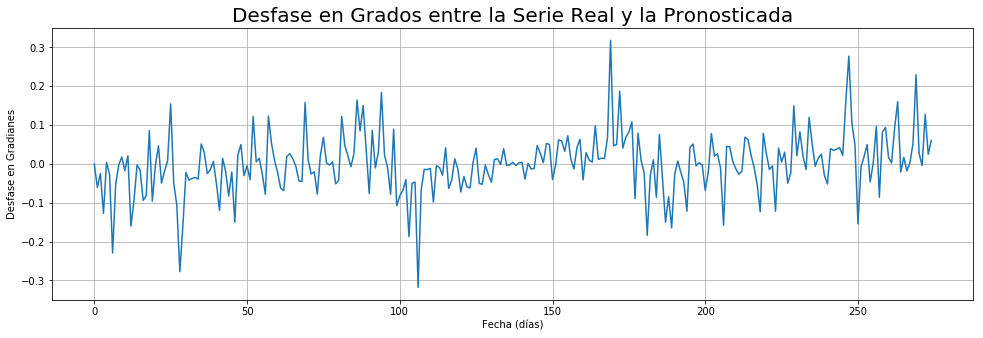

In [65]:
#Cálculo del defase entre los datos reales y los predichos

fft_real_data = np.fft.fft(Y_test2_inverse)
fft_predict_data = np.fft.fft(predictions_new)

fase_real = phase(fft_real_data)
fase_predict = phase(fft_predict_data)

desfase = fase_real - fase_predict 

plt.figure(figsize=(16.5,5))
pyplot.plot(desfase)

plt.grid(True)
plt.xlabel('Fecha (días)')
plt.ylabel('Desfase en Gradianes')
plt.title('Desfase en Grados entre la Serie Real y la Pronosticada', fontsize=20)
plt.savefig('66_Desfase.png')
pyplot.show()

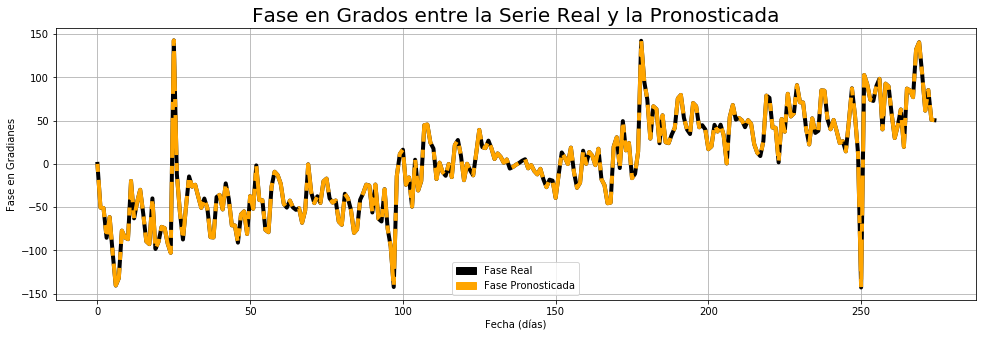

In [66]:
import matplotlib.patches as mpatches

plt.figure(figsize=(16.5,5))
pyplot.plot(fase_real, 'black', linewidth=4)
pyplot.plot(fase_predict, 'orange', dashes=[2, 2, 10, 2],linewidth=4)
plt.grid(True)

plt.xlabel('Fecha (días)')
plt.ylabel('Fase en Gradianes')
plt.title('Fase en Grados entre la Serie Real y la Pronosticada', fontsize=20)
black_patch = mpatches.Patch(color='black', label='Fase Real')
orange_patch = mpatches.Patch(color='orange', label='Fase Pronosticada')
plt.legend(handles=[black_patch, orange_patch])

plt.savefig('67_Fase_Real&Pronosticada.png')
pyplot.show()

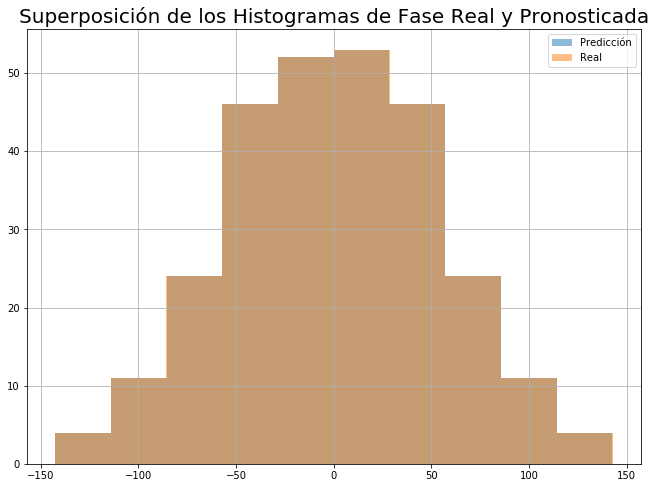

In [67]:
plt.figure(figsize=(11,8))
pyplot.hist(fase_predict,  alpha=0.5, label='Predicción')
pyplot.hist(fase_real, alpha=0.5, label='Real')
pyplot.legend(loc='best')
plt.title('Superposición de los Histogramas de Fase Real y Pronosticada', fontsize=20)
plt.grid(True)

plt.savefig('68_Histo_Real&Pronosticada.png')
pyplot.show()

275


<Figure size 1188x360 with 0 Axes>

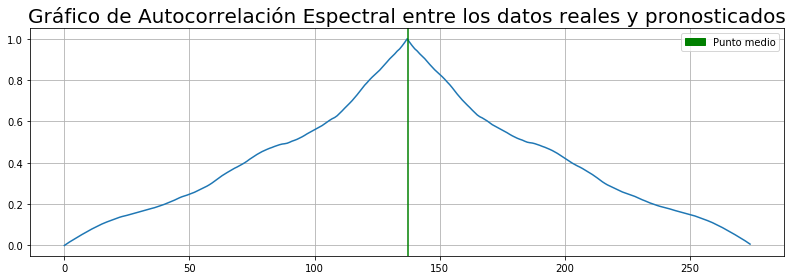

In [68]:
#Analisis mediante correlación cruzada
import numpy, scipy
from scipy.signal import correlate

plt.figure(figsize=(16.5,5))
long = len(Y_test2_inverse)
print(long)

signal_corr = correlate(Y_test2_inverse, predictions_new, mode='same') 

signal_normalized = (signal_corr-min(signal_corr))/(max(signal_corr)-min(signal_corr))

plt.figure(figsize=(12,4))
pyplot.plot(signal_normalized)
plt.axvline(x=long/2, color = 'green')

plt.title('Gráfico de Autocorrelación Espectral entre los datos reales y pronosticados', fontsize=20)
plt.grid(True)
green_patch = mpatches.Patch(color='green', label='Punto medio')
plt.legend(handles=[green_patch])

plt.tight_layout()
plt.savefig('69_spectral_autocorr.png')
pyplot.show()
